# 0.0 Imports

In [2]:
import pandas     as pd
import numpy      as np 
import seaborn    as sns   

from IPython.core.display  import HTML
from matplotlib            import pyplot as plt                       

## 0.1. Helper Functions

In [3]:
def jupyter_settings():
    """Definições padrões setadas para o uso o Jupyter Notebook."""
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Dataset

In [4]:
df_raw = pd.read_csv('/home/matheus/Projects/health_insurance_cross_sell/data/raw/train.csv')

# 1.0. Data Description

In [6]:
df1 = df_raw.copy()

In [7]:
df1.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [8]:
# Alterando para letras minusculas todas as colunas
cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code','previously_insured', 'vehicle_age', 
            'vehicle_damage', 'annual_premium','policy_sales_channel', 'vintage', 'response']

df1.columns = cols_new

## 1.1. Data Dimension

In [12]:
# Verificando a dimensão do dataset
print( 'Number of Rows:{}'.format(df1.shape[0]) )
print( 'Number of Columns:{}'.format(df1.shape[1]) )

Number of Rows:381109
Number of Columns:12


## 1.2. Data Types

In [14]:
# Verificando os tipos das variáveis das colunas
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.3. Check NA

In [16]:
# Verificando se possui NA
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.4. Data Descriptive

In [17]:
# Separação das variáveis categóricas e numéricas
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

In [18]:
# Verificando as métricas de negócio
# Central Tendency = mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion = std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# COncatenando as métricas
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


# 2.0. Feature Engineering

In [19]:
df2 = df1.copy()

In [20]:
# vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_year' if x == '>2 Years' else 'between_1_2_years' if x == '1-2 Year' else 'below_1_year') 

# vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# 3.0. Data Filtering

In [22]:
df3 = df2.copy()

Como no Data Descriptive não encontramos nada de discrepante nos dados, por hora não há o que filtrar

# 4.0. EDA

In [23]:
df4 = df3.copy()

## 4.1. Univariate Analysis

In [24]:
df4.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

O que o modelo quer fazer? <br>
Ele quer descobrir um hiperplano no espaço que pode separar essas classes<br>
Com isso, queremos encontrar algumas features que nos ajude a separar os clientes que querem o novo produto do que não querem <br>
Features que misturam isso são ruins, confundem mais que ajudam o classificador<br>
Olhamos se cada variável vai bagunçar ou ajudar a separar o dataset<br>
Procuramos variáveis que são separadas entre si

### 4.1.1. Age

<Axes: xlabel='response', ylabel='age'>

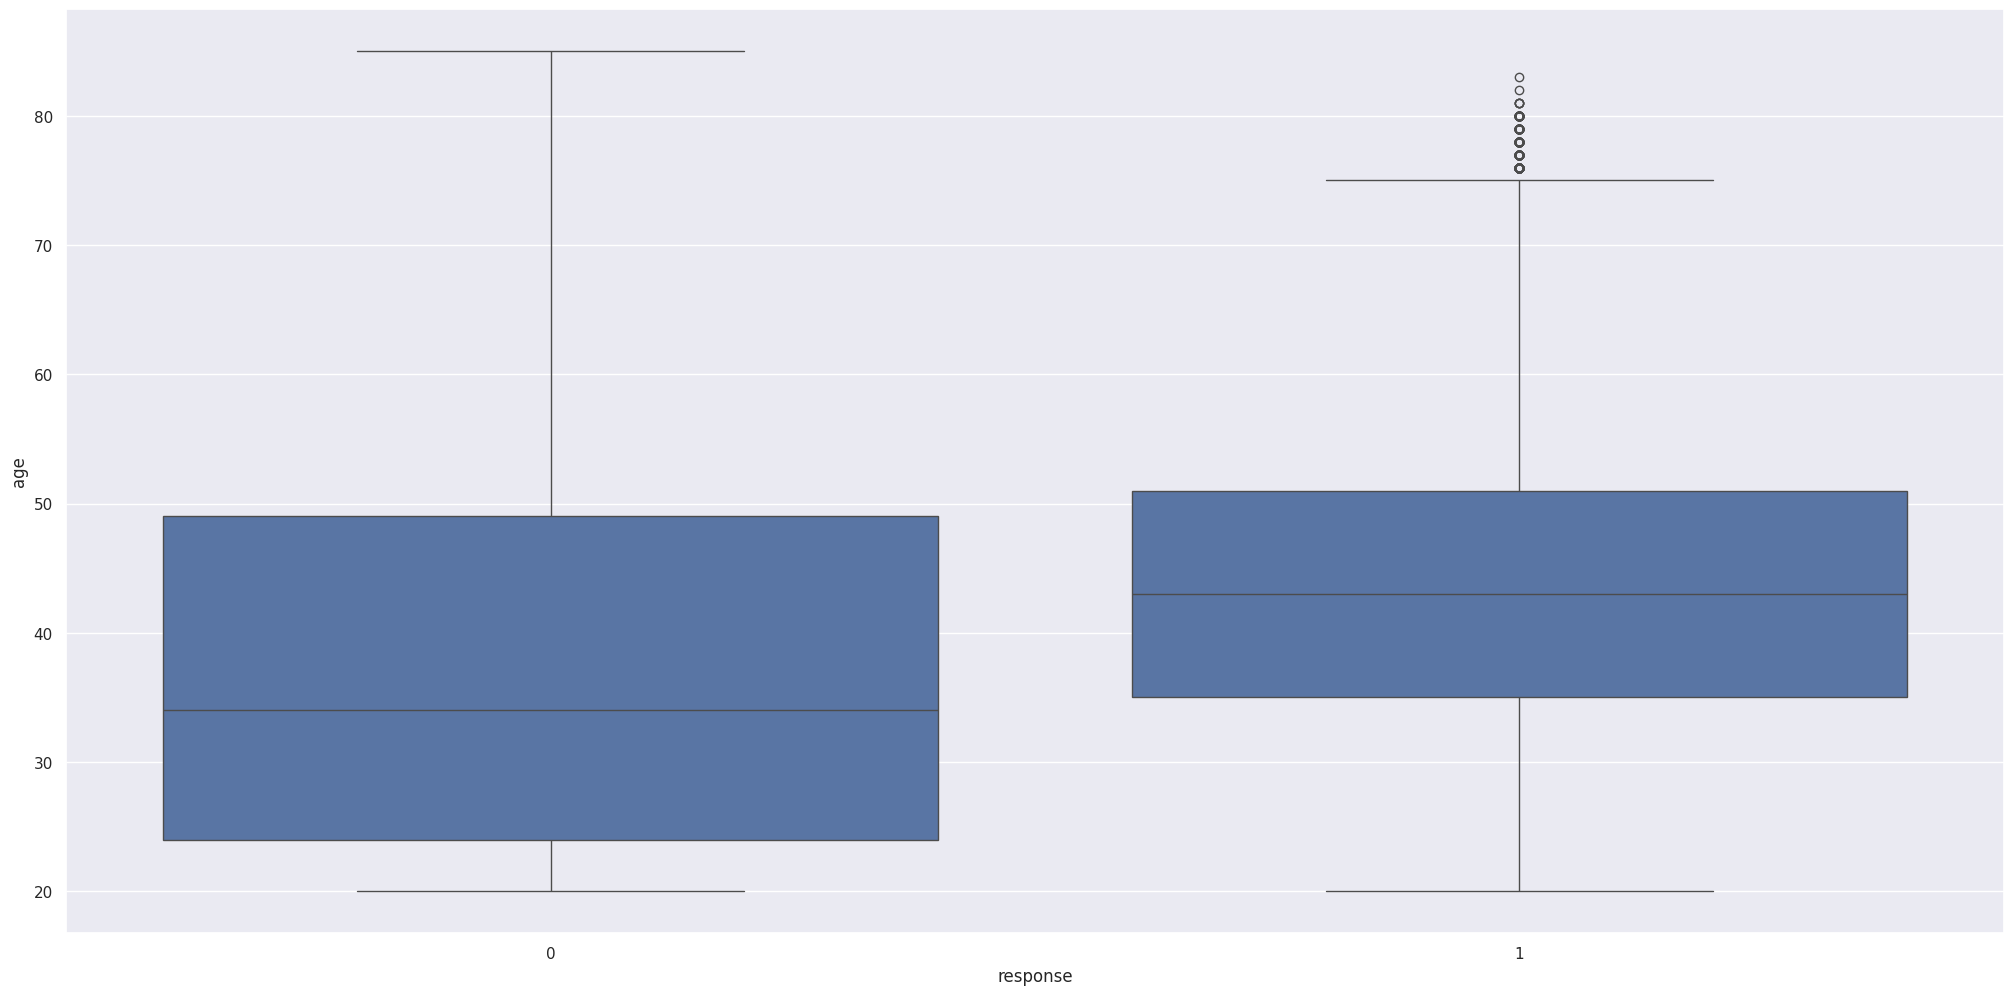

In [25]:
# age - Numeros Naturais
# Quero olhar as medianas de cada um dos grupos com relação a idade
sns.boxplot( x = 'response', y = 'age', data = df4)

#Vemos o distribuição deslocada, uma mediana maior pra quem adiquiriu o seguro, pessoas mais novas não tem interesse

<Axes: xlabel='age', ylabel='Count'>

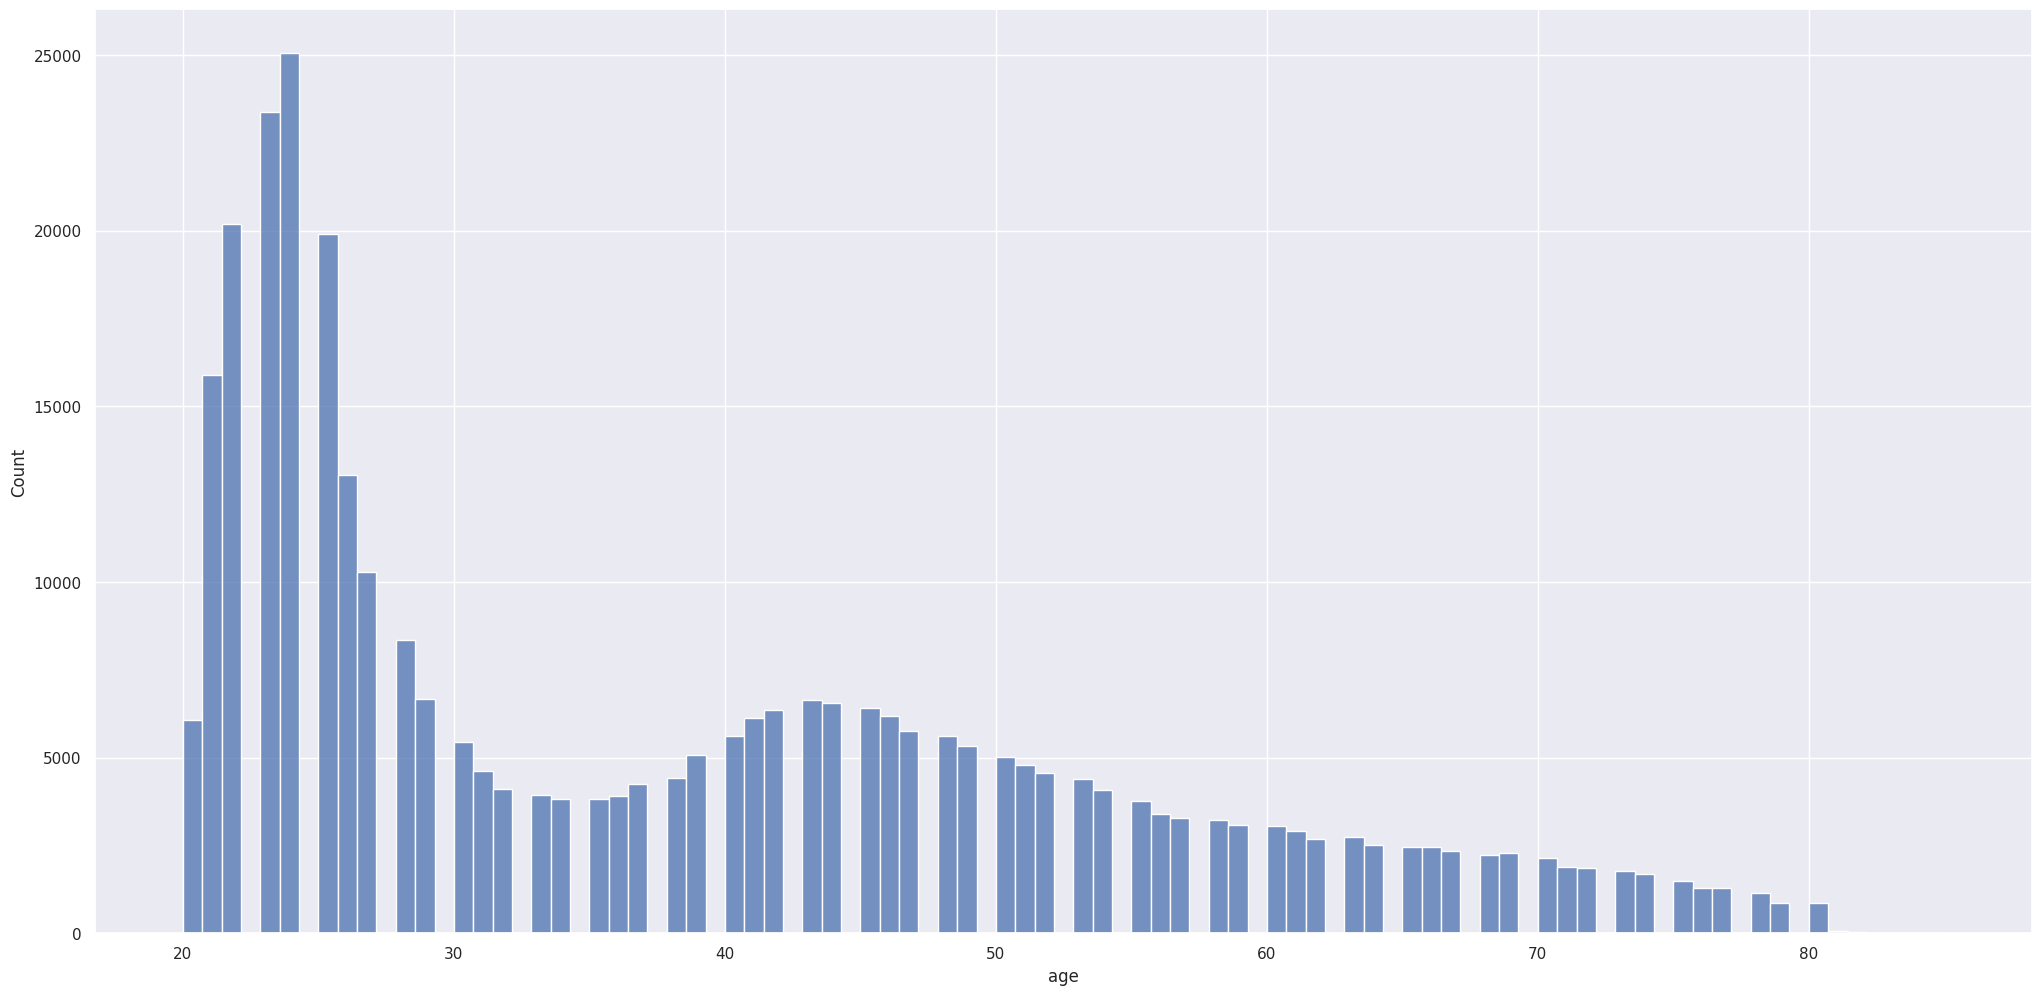

In [26]:
aux00 = df4.loc[ df4['response'] == 0, 'age' ]
sns.histplot( aux00 )

<Axes: xlabel='age', ylabel='Count'>

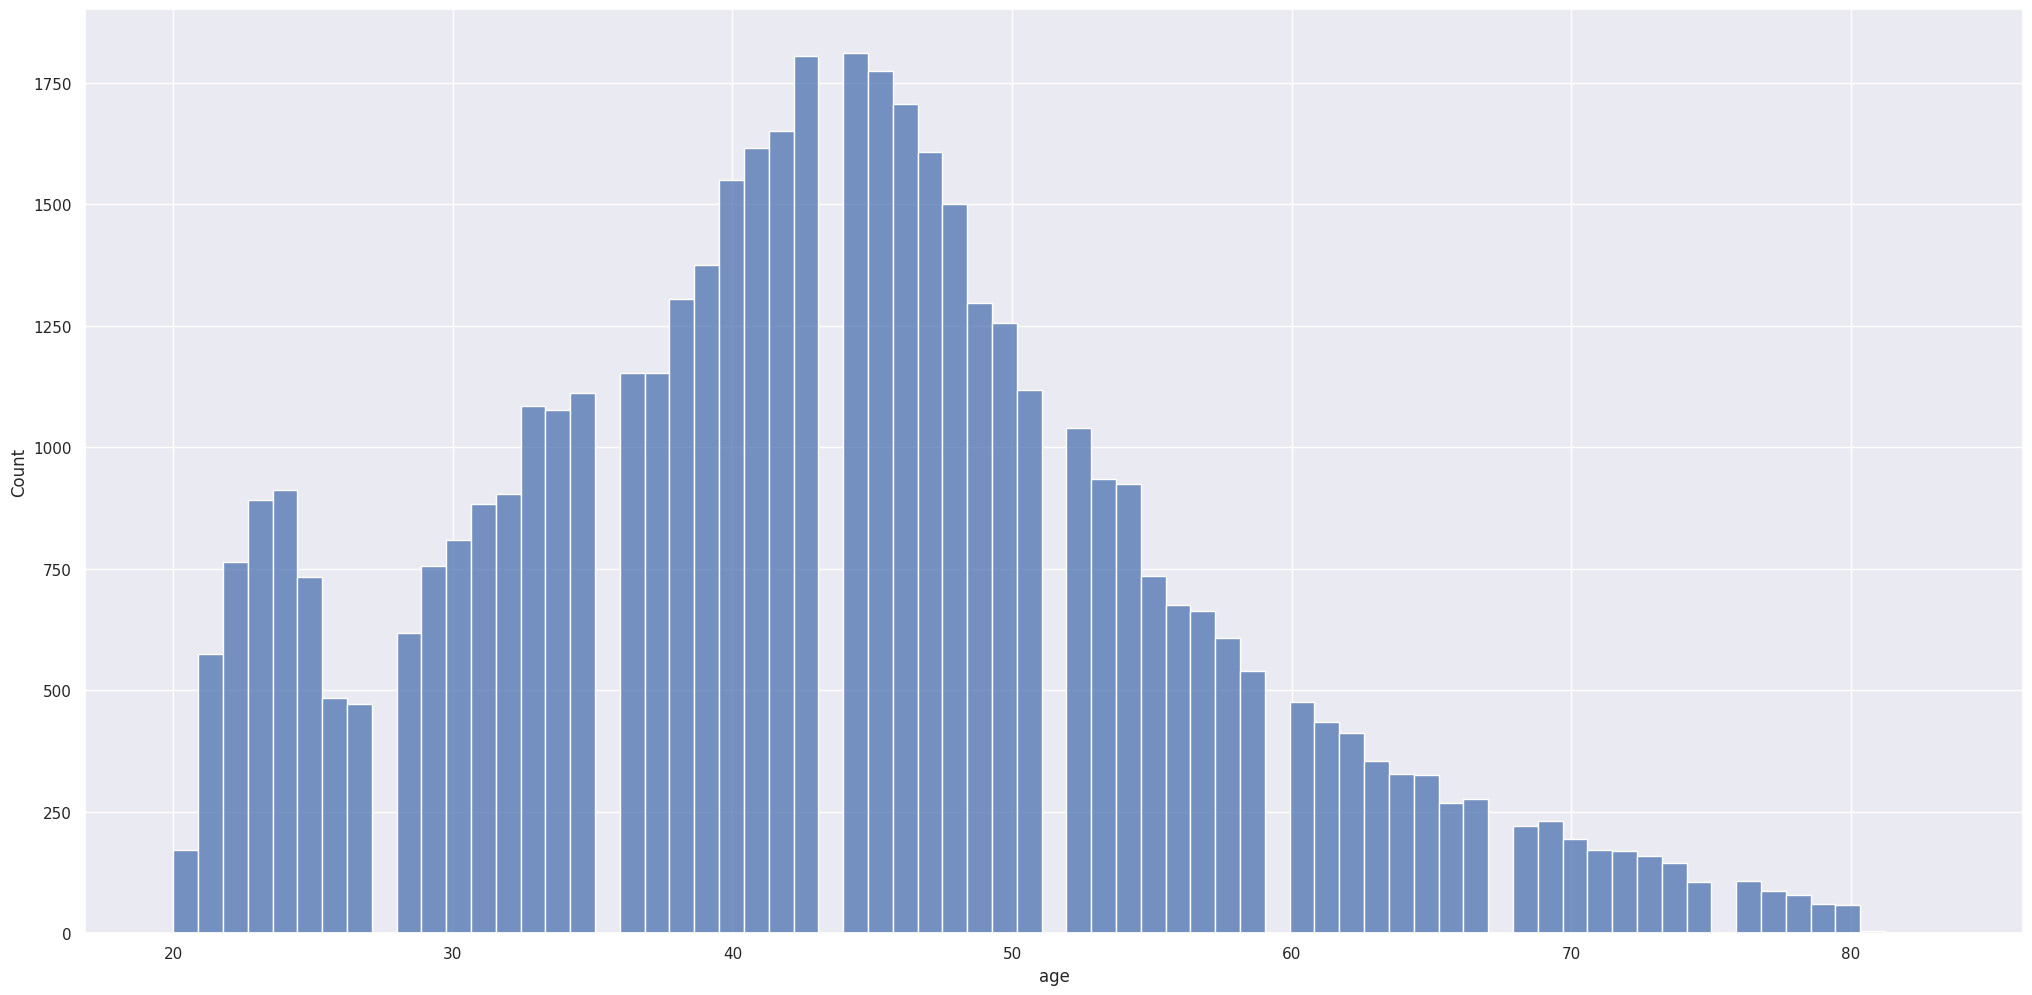

In [27]:
aux01 = df4.loc[ df4['response'] == 1, 'age' ]
sns.histplot( aux01 )

### 4.1.2. Annual Premium

<Axes: xlabel='response', ylabel='annual_premium'>

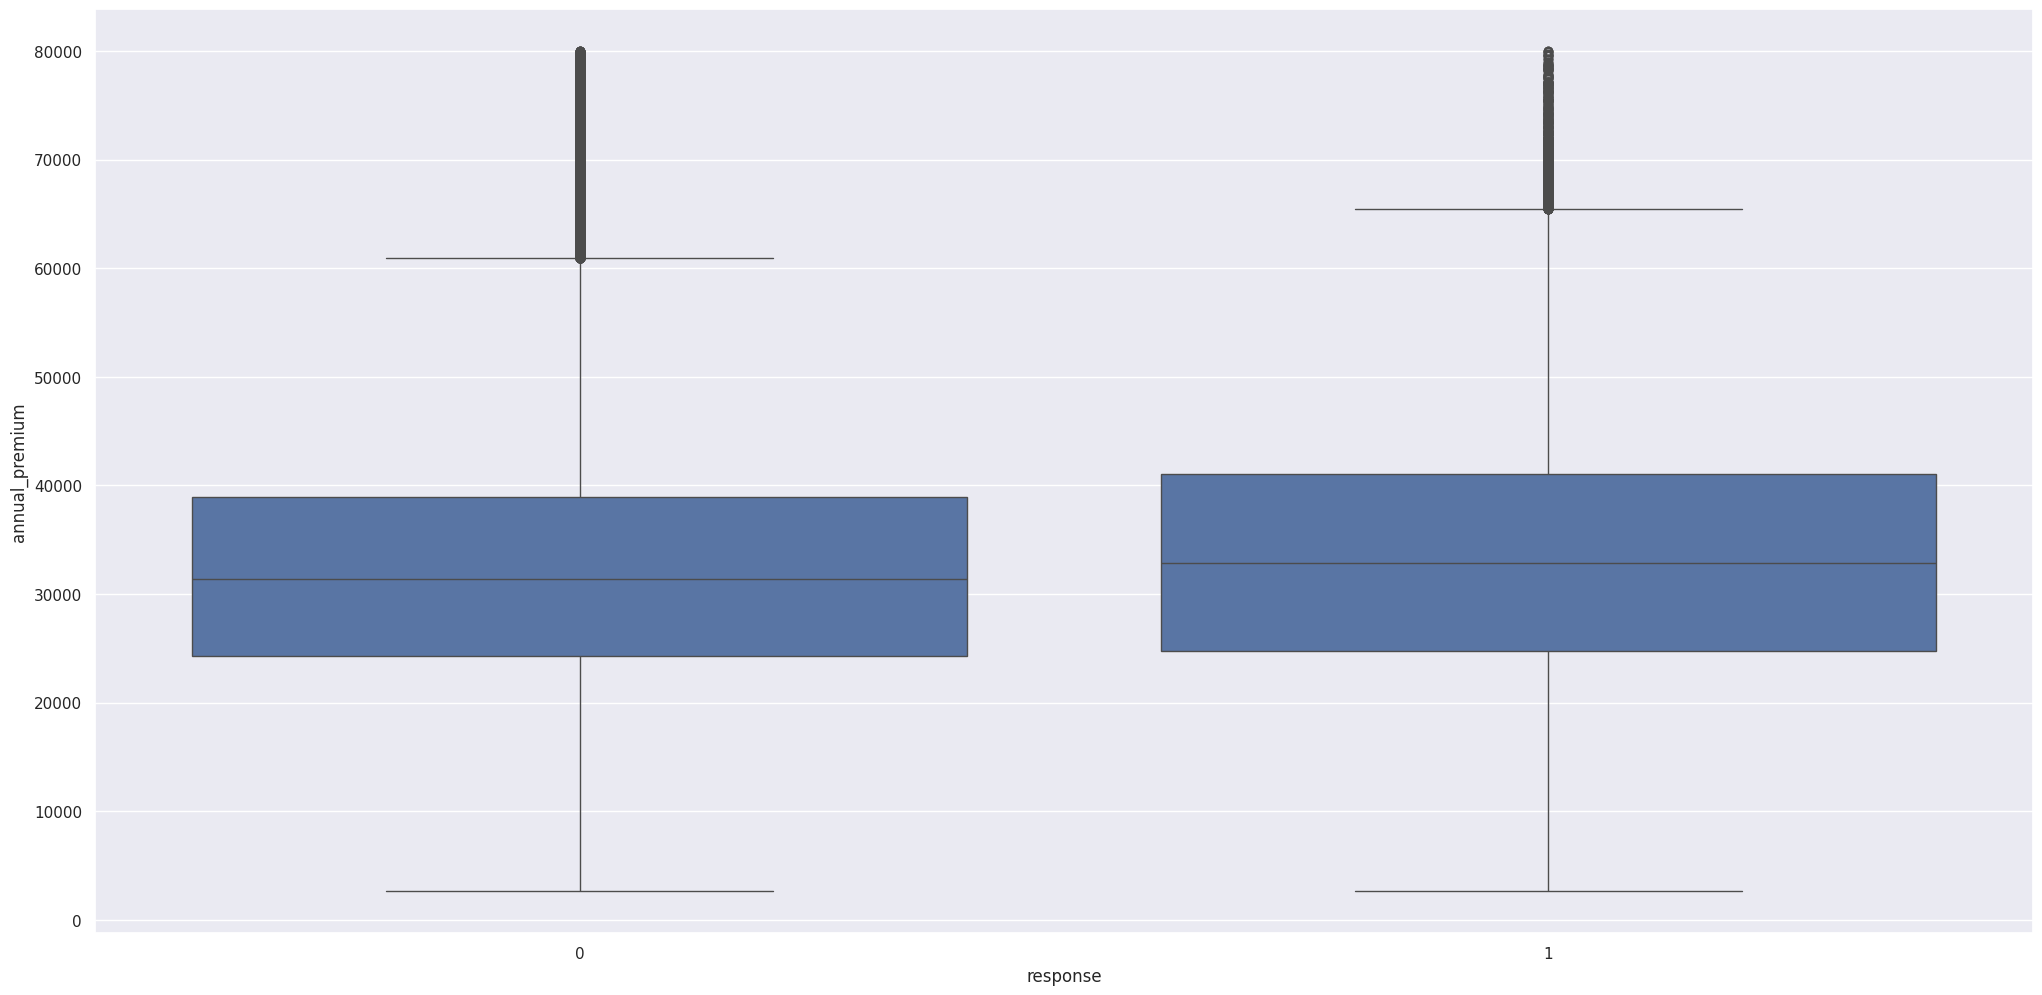

In [30]:
# annual_premium
aux = df4[ df4[ 'annual_premium'] < 80000 ]
sns.boxplot( x = 'response', y = 'annual_premium', data = aux)

# Muitos outliers
# Duas vezes a diferença interquartil
# Medianas muito proximas
#Sozinha não está diferenciando os dados
#Distribuição muito parecida, não me ajuda a diferenciar as observações nas classes
#Não é discriminatória

<Axes: xlabel='annual_premium', ylabel='Count'>

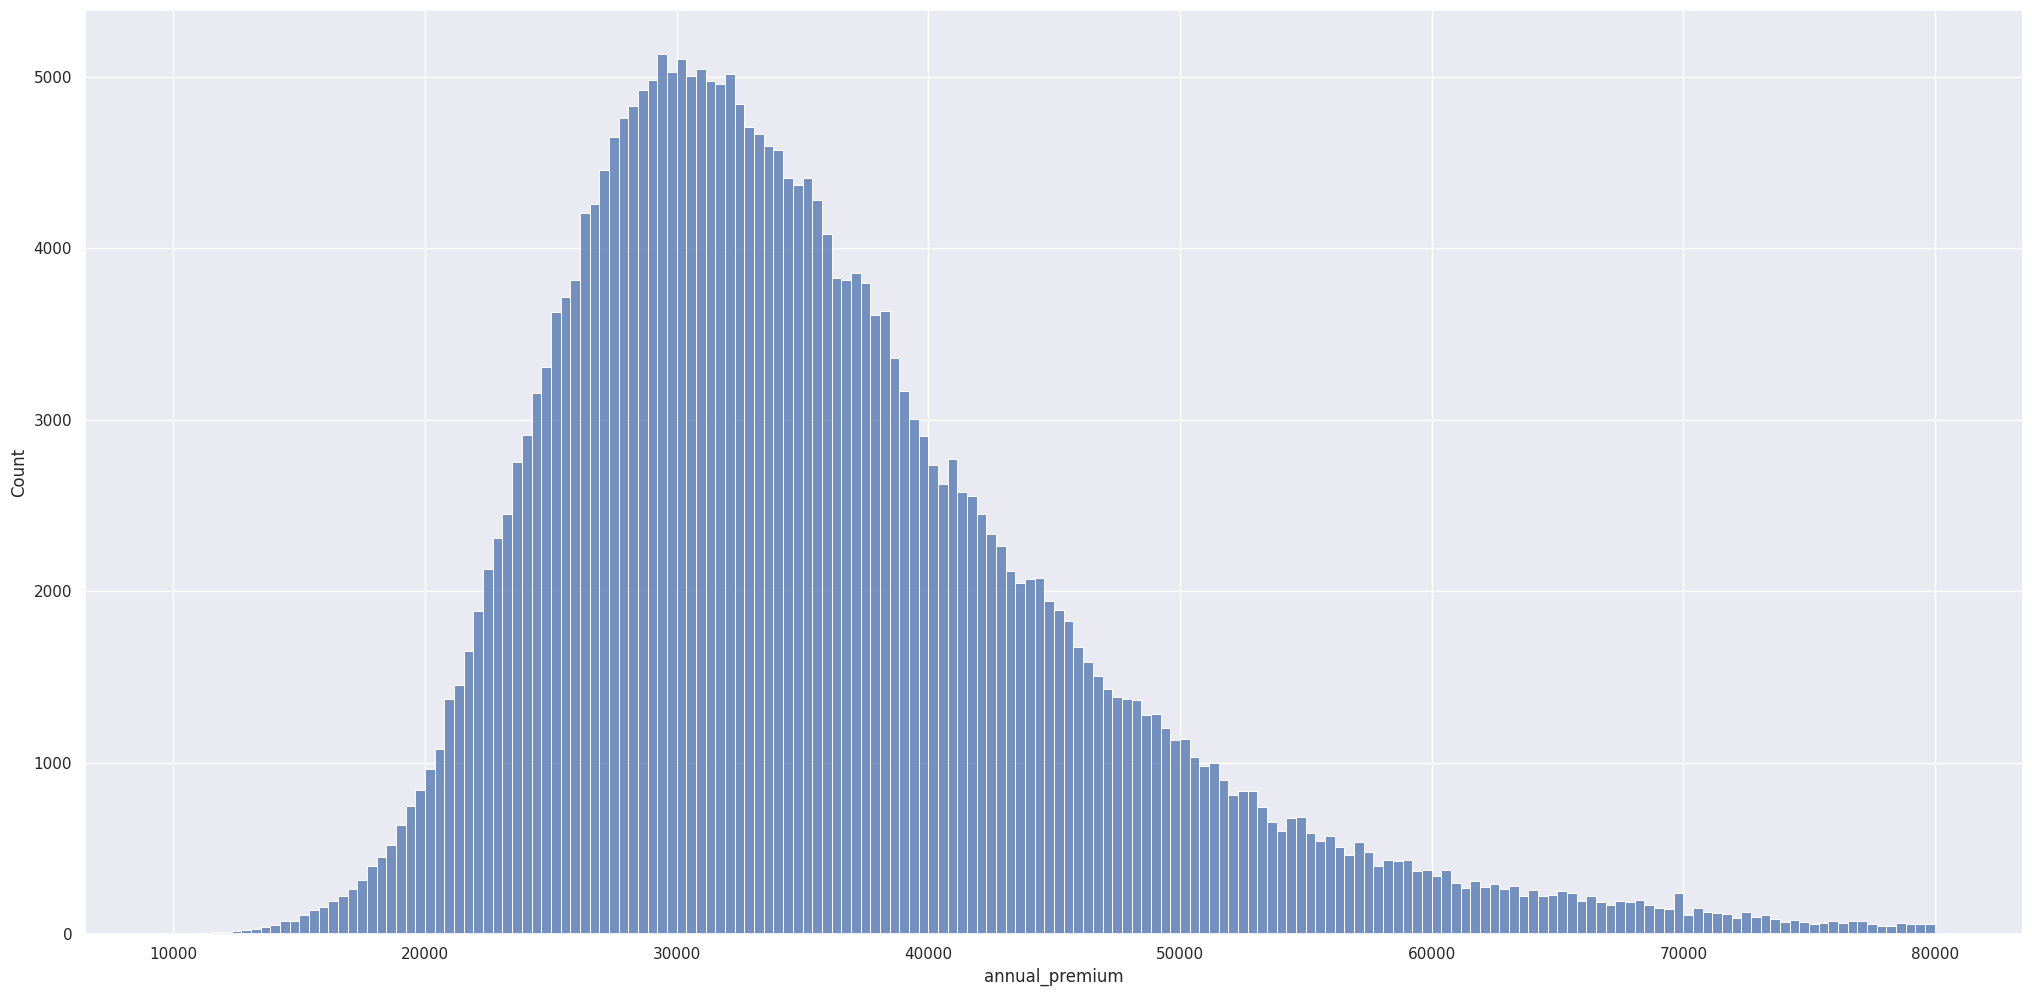

In [34]:
aux = df4[ ( df4[ 'annual_premium'] < 80000 ) & ( df4[ 'annual_premium'] > 10000 )]
aux00 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot( aux00 )

<Axes: xlabel='annual_premium', ylabel='Count'>

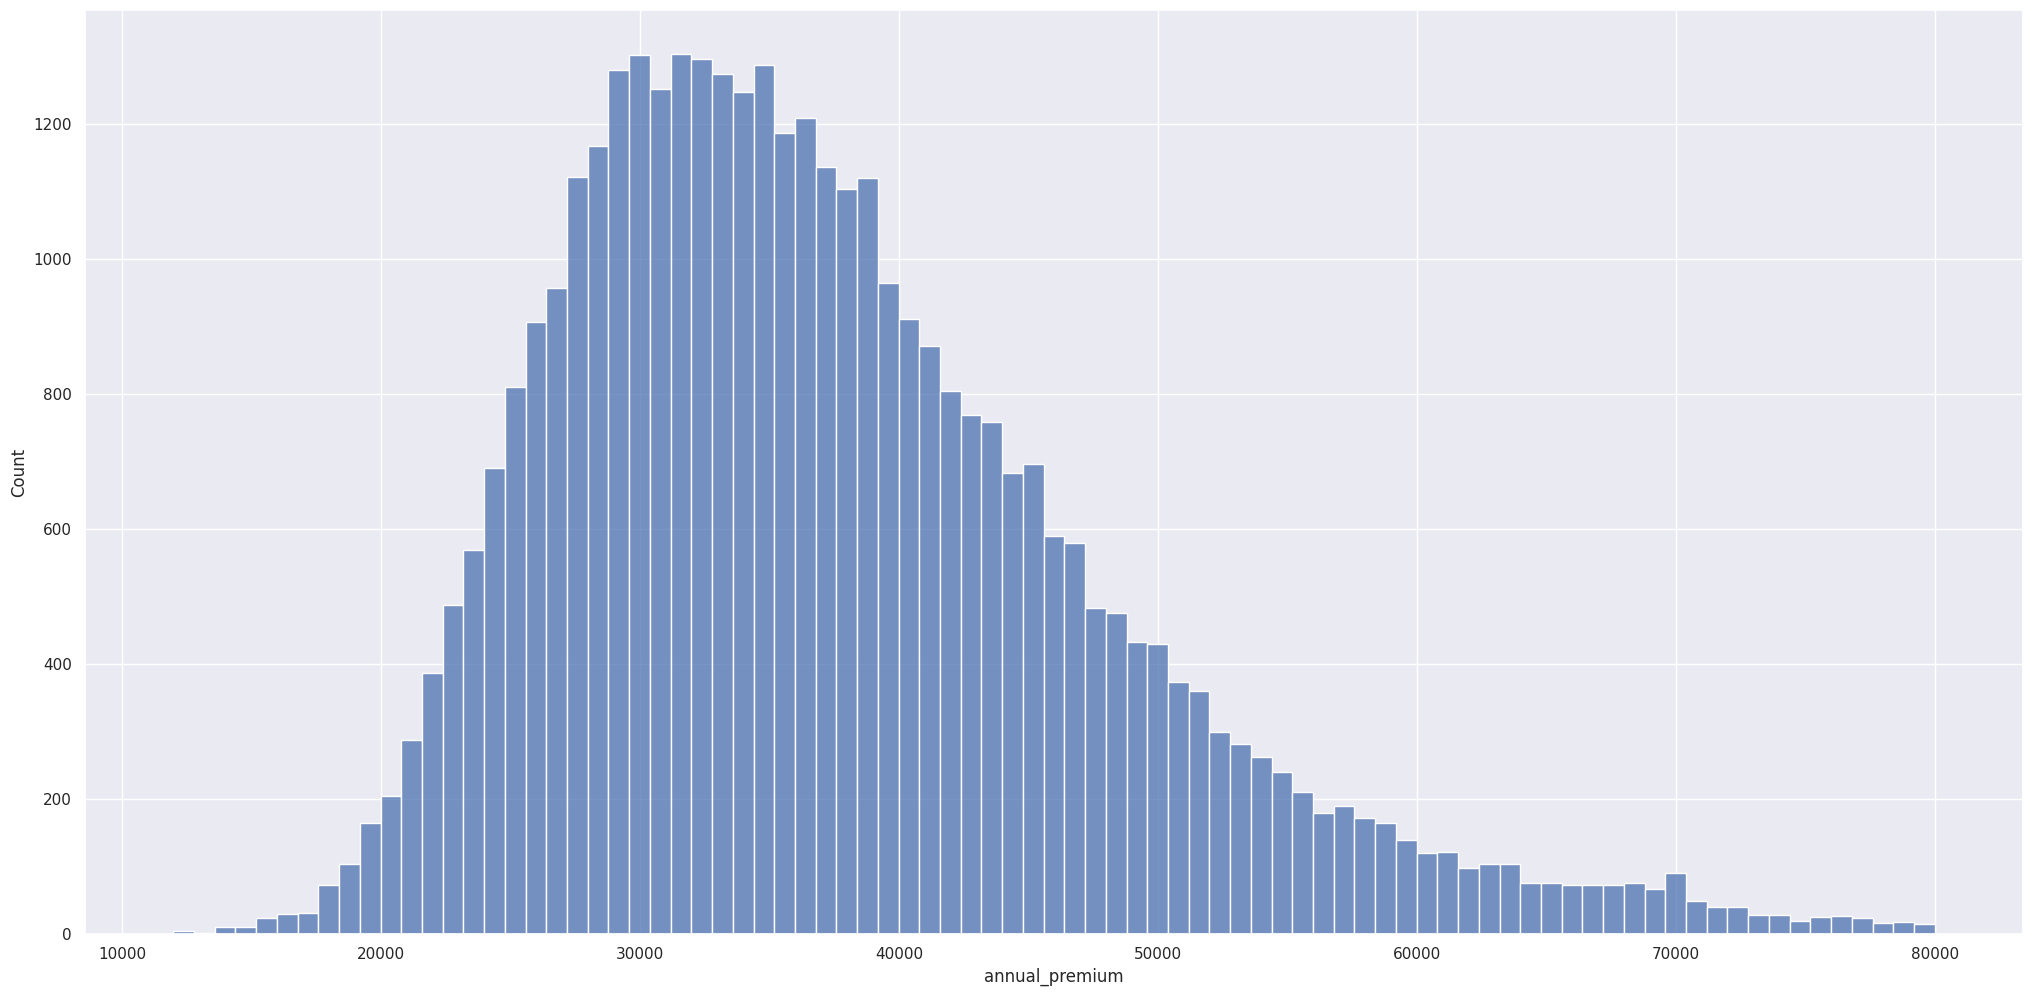

In [35]:
aux = df4[ ( df4[ 'annual_premium'] < 80000 ) & ( df4[ 'annual_premium'] > 10000 )]
aux00 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot( aux00 )

### 4.1.3. Driving License

<Axes: xlabel='response', ylabel='driving_license'>

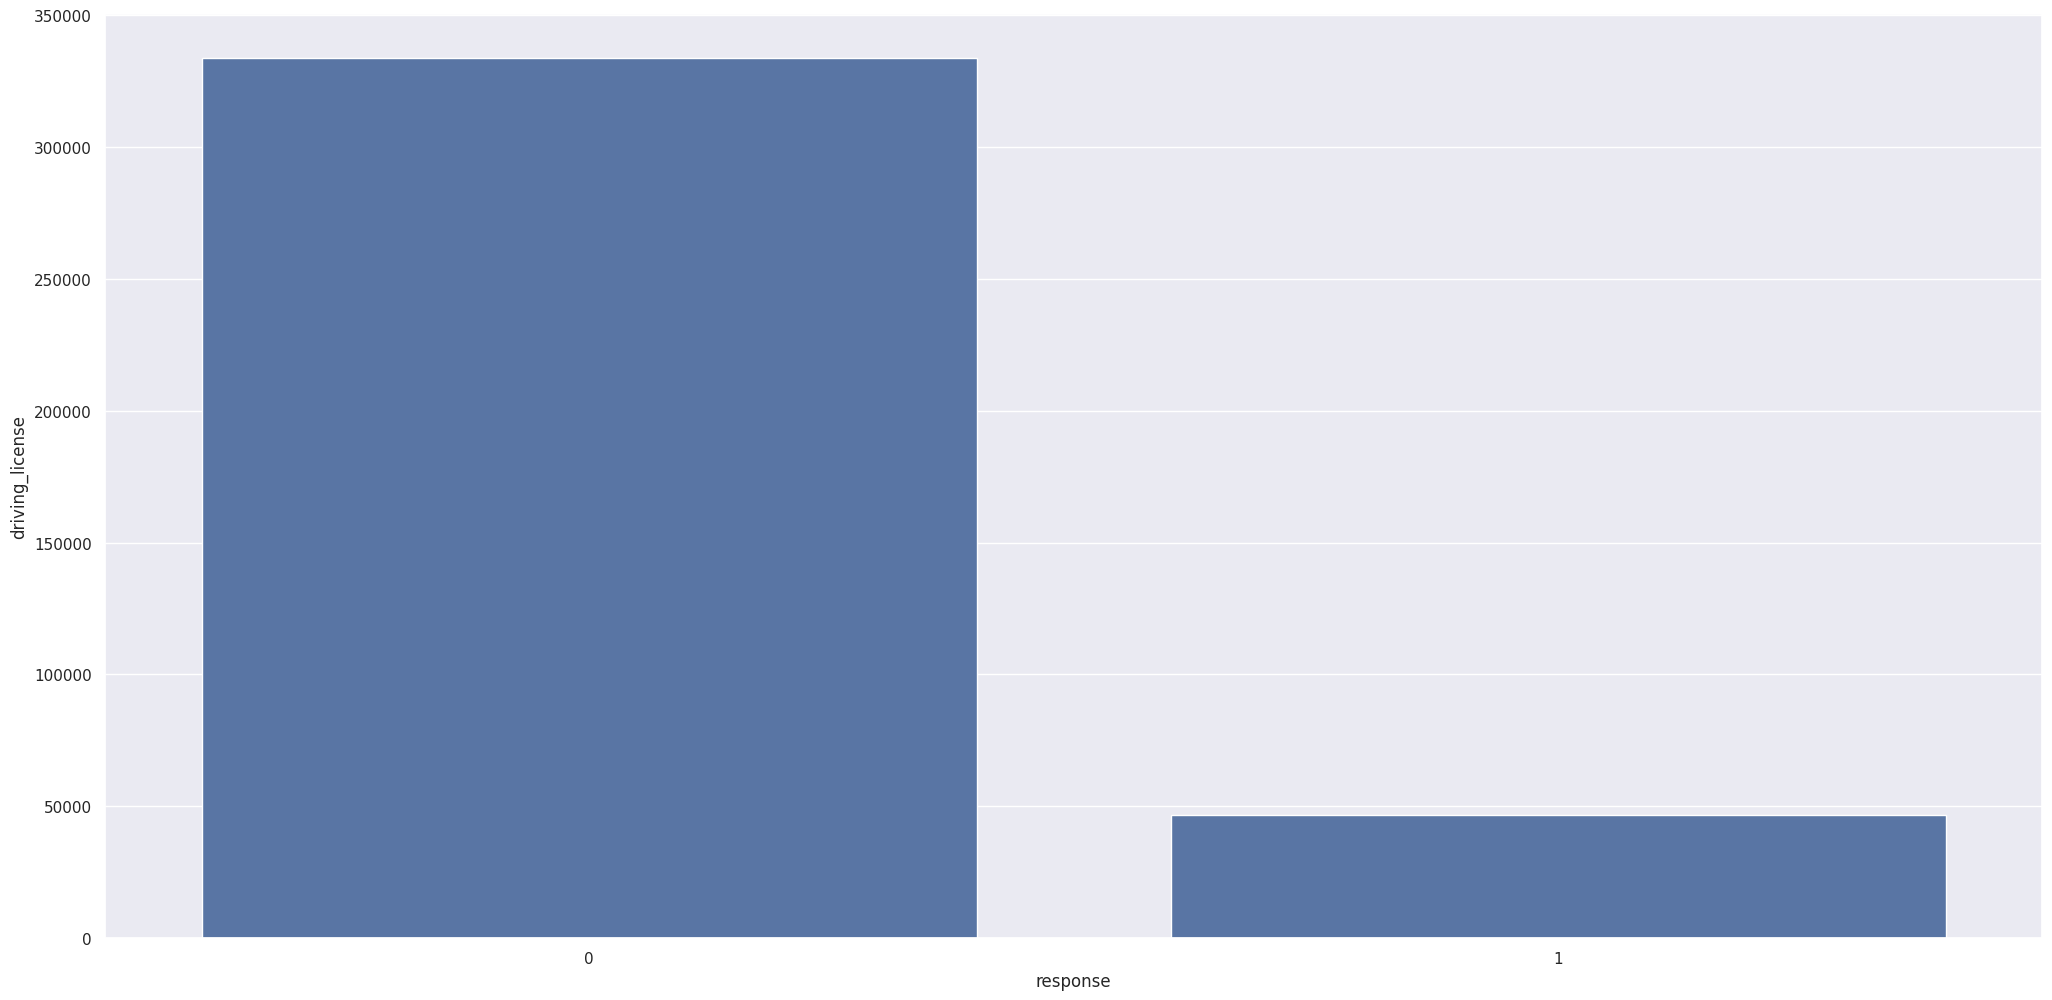

In [40]:
# driving_license
aux = df4[['driving_license', 'response']].groupby( 'response' ).sum().reset_index()
sns.barplot( x = 'response', y = 'driving_license', data = aux)

# 333628 pessoas que dirigem e não querem fazer o seguro de carro
# Isso é contraintuitivo pois a maioria das pessoas que dirigem não querem o seguro

### 4.1.4 Region Code

<Axes: xlabel='region_code', ylabel='id'>

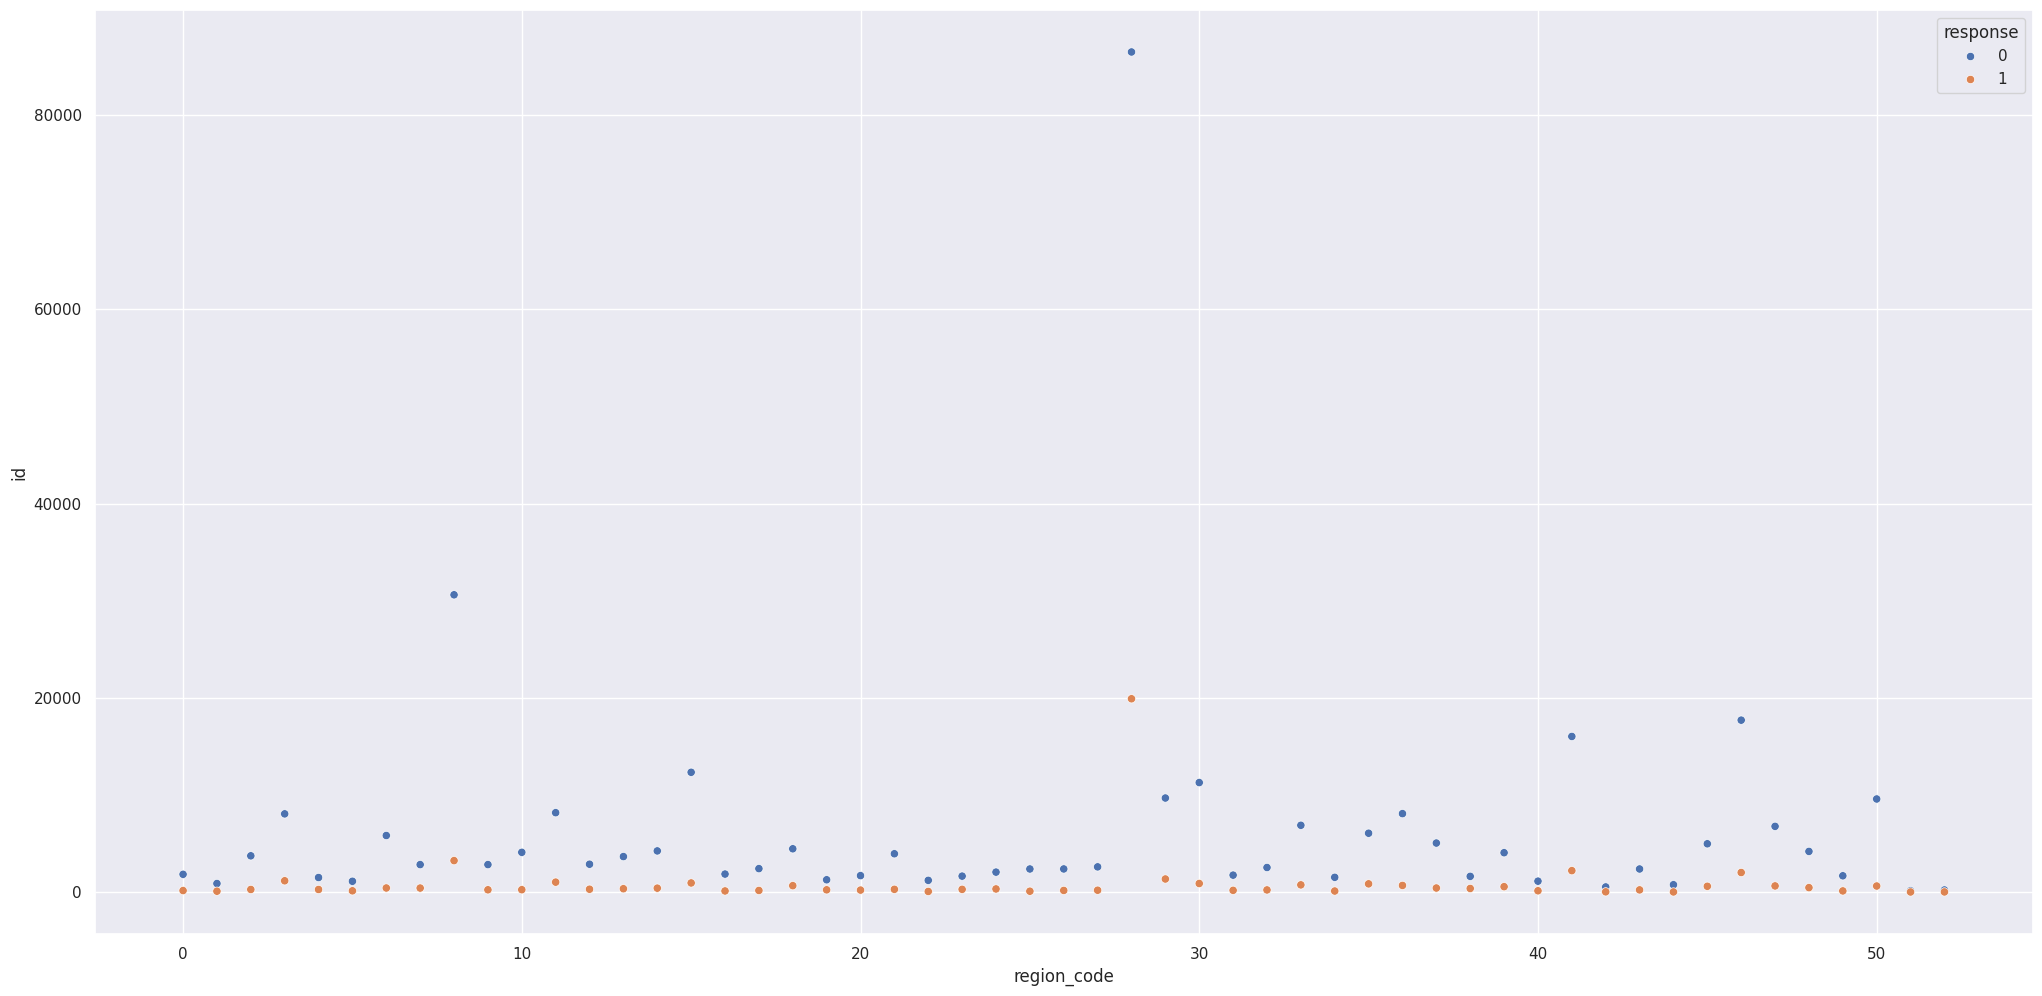

In [43]:
# region_code
aux0 = df4[[ 'id', 'region_code', 'response']].groupby( ['region_code', 'response']).count().reset_index()

sns.scatterplot( x = 'region_code', y = 'id', hue = 'response', data = aux0)

# No region_code 29 aproximadamente, temos uma grande quantidade de 0 em relação a 1
# Porém no restante nada que resolva o problema pois está muito misturado
# Esta variável sozinha não ajuda

### 4.1.5 Previously Insured

In [44]:
# previously_insured
df4[['previously_insured', 'response']].head()

,previously_insured,response
0,0,1
1,0,0
2,0,1
3,1,0
4,1,0


In [ ]:
# gender

In [ ]:
# vehicle_age

In [ ]:
# vehicle_damage

In [ ]:
# policy_sales_channel

In [ ]:
# vintage

In [ ]:
# response

# 5.0. Feature Selection

# 6.0. Data Preparation

# 7.0. Machine Learning Model